In [ ]:
#| default_exp prediction.core
#| default_cls_lvl 3

In [ ]:
#| export
from tsfast.data import *
from tsfast.models import *
from tsfast.learner import *
# from tsfast.dataloaders import *
from fastai.basics import *

In [ ]:
from nbdev.config import get_config

## Create a dataloader for multi step ahead prediction
We create a prediction dataloader by including the system output with a timeshift to the input. The output is shifted one step so that it is always older than the predicted one. 

In [ ]:
project_root = get_config().config_file.parent
f_path = project_root / 'test_data/WienerHammerstein'

In [ ]:
hdf_files = get_hdf_files(f_path)
init_sz = 300
u = ['u']
y = ['y']
seq = DataBlock(blocks=(SequenceBlock.from_hdf(u+y,TensorSequencesInput,clm_shift=[0,-1]),
                        SequenceBlock.from_hdf(y,TensorSequencesOutput,clm_shift=[-1])),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=500+1,stp_sz=100,clm='u')]),
                 splitter=ApplyToDict(FuncSplitter(lambda o: 'valid' in str(o))))
dls_pred = seq.dataloaders(hdf_files,bs=32,shuffle=True)

In [ ]:
dls_pred.one_batch()[0][0].shape,dls_pred.one_batch()[0][1].shape 

(torch.Size([500, 2]), torch.Size([500, 2]))

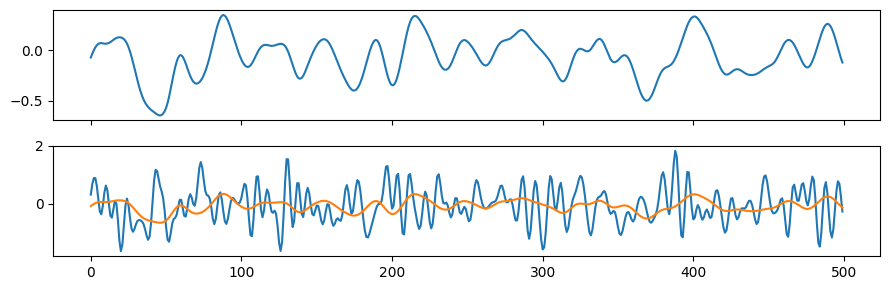

In [ ]:
dls_pred.show_batch(max_n=1)

## Create a learner Callback for prediction
Instead of creating a specialized dataloader we can instead create a Callback for the learner to add the historic system output data. This creates more flexibility for the learner and requires only one kind of dataloader per dataset.

In [ ]:
#| export
class PredictionCallback(Callback):
    'Concatenates the optionally normalized system output to the input data for autoregression, assumes 1-tuple as input'
    
    order= -56 #the callback has to be the first one executed, so everything else has the correct database
    
    def __init__(self,
                 t_offset=1, #the number of steps output is shifted in the past, shortens the sequence length by that number
                 std=None, #standard deviation of the output tensor
                 mean=None #mean of the output tensor
                ):
        super().__init__()
        self.t_offset = t_offset
        self.norm = None
        
        if not(std is None or mean is None):
            self.init_normalize_values(mean,std)

    def init_normalize(self, batch,axes = [0,1]):
        x = batch[1]
        mean = x.mean(axes, keepdim=True)
        std = x.std(axes, keepdim=True)
        self.init_normalize_values(mean,std)
        
    def init_normalize_values(self, mean, std):
        self.norm = Normalizer1D(mean,std)


    def before_batch(self):
        #output has to be casted to the input tensor type
        x = self.x
        y = self.yb[0].as_subclass(type(x))

        if self.t_offset != 0:
            x = x[:,self.t_offset:,:]
            y = y[:,:-self.t_offset,:]

            #shorten the output by the same size
            self.learn.yb = tuple((y[:,self.t_offset:,:] for y in self.yb))

        if not self.norm is None: y = self.norm.normalize(y)

        #concatenate and reconvert to tuple
        self.learn.xb = (torch.cat((x,y), dim=-1),)

        # #approach for handling tuples as input and output
        # self.learn.xb = tuple((torch.cat((x,y.as_subclass(type(x))), dim=-1) 
        #                        for x,y in zip(self.xb,self.yb)))

We create a dataloader without system output as input and compare the signals after the callback.

In [ ]:
seq = DataBlock(blocks=(SequenceBlock.from_hdf(u,TensorSequencesInput),
                        SequenceBlock.from_hdf(y,TensorSequencesOutput)),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=500,stp_sz=100,clm='u')]),
                 splitter=ApplyToDict(FuncSplitter(lambda o: 'valid' in str(o))))
dls = seq.dataloaders(hdf_files,bs=32)

Evaluate that a simulation model works with the dataset

In [ ]:
model = SimpleRNN(1,1)
Learner(dls,model,loss_func=nn.MSELoss()).fit(1)

epoch,train_loss,valid_loss,time
0,0.029716,0.006990,00:01


and a prediction model which expects a 2d input does not work without the callback

In [ ]:
model = SimpleRNN(2,1)
test_fail(lambda: Learner(dls,model,loss_func=nn.MSELoss()).fit(1))

epoch,train_loss,valid_loss,time


In [ ]:
# dls_pred.show_batch(max_n=1)
# dls.show_batch(max_n=1)

In [ ]:
model = SimpleRNN(2,1)
pred_callback = PredictionCallback(1)
pred_callback.init_normalize(dls.one_batch())
lrn = Learner(dls,model,loss_func=nn.MSELoss(),cbs=pred_callback)
lrn.fit(1)

epoch,train_loss,valid_loss,time


In [ ]:
#| include: false
import nbdev; nbdev.nbdev_export()